# Long term simulation with SWIM-ODE and ELM-ODE for travelling sine-wave (t = 100)

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../src')
from swimpde import Domain
from swimpde import BoundaryCompliantAnsatz
from swimpde import AdvectionSolver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm
import time
import matplotlib.cm as cm


### Problem Setup

In [2]:
n_space = 256 # Number of test points in space
n_t = 100 #Number of test points in time
t_eval = np.linspace(0, 1000, n_t) # Time domain
x_lim = [0, 2 * np.pi] # Space domain: 1-d space with uniform grid
n_s = 1000 # Number of collocation points in space

# initial condition
def u0(x):
    return np.sin(x)

# forcing
def forcing(x, t):
    return np.zeros(x.shape[0])

# Analytical solution
def analytical_sol(x, t, conv_coeff):
    return np.sin(x - conv_coeff * t)

x_space = np.linspace(x_lim[0], x_lim[1], n_s).reshape((-1, 1))
# interior points
x_space_inner = x_space[1:-1]
interior_points = x_space_inner

# coordinates of boundary points (excluding corners)
left = x_lim[0]
right = x_lim[1]
boundary_points = np.row_stack([left, right])

domain = Domain(
    interior_points=interior_points,
    boundary_points=boundary_points,
)

# Set boundary conditions
boundary_condition = "periodic"

# Outer basis functions
def periodic_outer_basis_sine(x_space, n_outer_basis=None, initial_condition=None):
        return np.column_stack([
            sine_cos(x_space * (i+1))
            for i in range(n_outer_basis//2)
            for sine_cos in [np.sin, np.cos]
    ])


### Hyper-parameters

In [3]:
# SWIM and ELM: Hyper-parameters (First entry: SWIM, second entry: ELM)
reg_OBF = [1e-10, 1e-10] 
svd_cutoff = [1e-10, 1e-10] 
reg_pinv_ic = reg_OBF # Regularization const for pseudo-inverse and least squares solution for IC
conv_coeff = 1. # beta (change convection coefficient!!)
n_IBFs_factors = [10, 10]
ratios = [40, 40]


### Fit and compute errors (averaged over 3 seeds) for SWIM-ODE and ELM-ODE and 

In [4]:
# Parameter sampler for ELM: Sample weights from a normal distribution and biases uniformly from [-4, 4]
def sample_parameters_randomly(x, _, rng):
    weights = rng.normal(loc=0, scale=1, size=(x.shape[1], n_IBF_elm))
    biases = rng.uniform(low=-4, high=4, size=(1, n_IBF_elm)) # low=-np.pi, high=np.pi,  2 * np.pi
    idx0 = None
    idx1 = None
    return weights, biases, idx0, idx1

# Test Data
x_space_test = np.linspace(np.min(x_space), np.max(x_space), n_space).reshape((-1, 1))
u_true_test = analytical_sol(x_space_test, t_eval, conv_coeff=conv_coeff).T

seeds = [1, 2, 3]
# Hyper-parameters for SWIM and ELM
n_OBF_swim = int(n_s//ratios[0]) #2 # Number of outer basis functions
n_IBF_swim = int(n_IBFs_factors[0] * n_OBF_swim) # Number of inner basis functions
n_OBF_elm = int(n_s//ratios[1]) #2 # Number of outer basis functions
n_IBF_elm = int(n_IBFs_factors[1] * n_OBF_elm) # Number of inner basis functions

# Loop over different seeds
rmse_swim = np.ones((len(seeds), ))
rmse_swim_rs = np.ones((len(seeds), ))
rmse_elm = np.ones((len(seeds), ))
rel_err_swim = np.ones((len(seeds), ))
rel_err_swim_rs = np.ones((len(seeds), ))
rel_err_elm = np.ones((len(seeds), ))
time_swim = np.ones((len(seeds), ))
time_swim_rs = np.ones((len(seeds), ))
time_elm = np.ones((len(seeds), ))
l2_rel_err_elm = np.ones((len(seeds), ))
l2_rel_err_swim = np.ones((len(seeds), ))

j = 0
rmse_elms = []
rmse_swims = []
l2_rel_err_swims = []
l2_rel_err_elms = []

for s in seeds:
    # Set inner basis functions
    ansatz_elm = BoundaryCompliantAnsatz(
        n_outer_basis=n_OBF_elm,
        n_inner_basis=n_IBF_elm,
        activation="tanh",
        target_gen=periodic_outer_basis_sine,
        random_state=s,
        regularization_scale=reg_OBF[1],
        parameter_sampler = sample_parameters_randomly
    )
    ansatz_swim = BoundaryCompliantAnsatz(
        n_outer_basis=n_OBF_swim,
        n_inner_basis=n_IBF_swim,
        activation="tanh",
        target_gen=periodic_outer_basis_sine,
        random_state=s,
        regularization_scale=reg_OBF[0],
    )

    # Set advection solver
    adv_solver_elm = AdvectionSolver(
        domain=domain, 
        ansatz=ansatz_elm,
        u0=u0,
        boundary_condition=boundary_condition,
        c=conv_coeff,
        forcing=forcing,
        regularization_scale=reg_OBF[1],
    )
    adv_solver_swim = AdvectionSolver(
        domain=domain, 
        ansatz=ansatz_swim,
        u0=u0,
        boundary_condition=boundary_condition,
        c=conv_coeff,
        forcing=forcing,
        regularization_scale=reg_OBF[0],
    )

    # Compute weights and biases of the SWIM network
    time_blocks = 1
    #sol, solver_status = adv_solver_swim.fit_time_blocks(t_span=[0, np.max(t_eval)], time_blocks=time_blocks,rtol = 1e-10, atol = 1e-10);
    t_swim_start = time.time()
    sol, solver_status = adv_solver_swim.fit(t_span=[0, np.max(t_eval)], rtol = 1e-8, atol = 1e-8, svd_cutoff=1e-11);
    t_swim_stop = time.time()
    time_swim[j] = t_swim_stop - t_swim_start
    
    t_elm_start = time.time()
    adv_solver_elm.fit(t_span=[0, np.max(t_eval)], rtol = 1e-8, atol = 1e-8, svd_cutoff=1e-11);
    t_elm_stop = time.time()
    time_elm[j] = t_elm_stop - t_elm_start

    # Evaluate solution
    u_elm_test = adv_solver_elm.evaluate(x_eval=x_space_test, t_eval = t_eval).T
    u_swim_test = adv_solver_swim.evaluate(x_eval=x_space_test, t_eval = t_eval).T #, solver_status=solver_status

    # Store useful info for plotting
    mse_elm = mean_squared_error(u_true_test, u_elm_test)  # mean squared error
    rmse_elm[j] = np.sqrt(mse_elm)  # Root Mean Squared Error
    mse_swim = mean_squared_error(u_true_test, u_swim_test)  # mean squared error
    rmse_swim[j] = np.sqrt(mse_swim)  # Root Mean Squared Error
    l2_rel_err_elm[j] = np.linalg.norm(u_elm_test - u_true_test, 2)/np.linalg.norm(u_true_test, 2)
    l2_rel_err_swim[j] = np.linalg.norm(u_swim_test - u_true_test, 2)/np.linalg.norm(u_true_test, 2)
    j += 1

    # All metrics
    rmse_elm = np.ones((np.shape(t_eval))) * 100
    rmse_swim = np.ones((np.shape(t_eval))) * 100
    l2_rel_err_swim = np.ones((np.shape(t_eval))) * 100
    l2_rel_err_elm = np.ones((np.shape(t_eval))) * 100
    for t in range(len(t_eval)):
        mse_elm = mean_squared_error(u_true_test[t, :], u_elm_test[t, :])  # mean squared error
        rmse_elm[t] = np.sqrt(mse_elm)  # Root Mean Squared Error
        mse_swim = mean_squared_error(u_true_test[t, :], u_swim_test[t, :])  # mean squared error
        rmse_swim[t] = np.sqrt(mse_swim)  # Root Mean Squared Error
        l2_rel_err_elm[t] = np.linalg.norm(u_elm_test[t, :] - u_true_test[t, :], 2)/np.linalg.norm(u_true_test[t, :], 2)
        l2_rel_err_swim[t] = np.linalg.norm(u_swim_test[t, :] - u_true_test[t, :], 2)/np.linalg.norm(u_true_test[t, :], 2)
    rmse_elms.append(rmse_elm)
    rmse_swims.append(rmse_swim)
    l2_rel_err_elms.append(l2_rel_err_elm)
    l2_rel_err_swims.append(l2_rel_err_swim)

time_elm = np.mean(time_elm)
time_swim = np.mean(time_swim)

print('Time ELM: ', time_elm, 'time_swim', time_swim)

rmse_elm_avg = (rmse_elms[0] + rmse_elms[1] + rmse_elms[2]) / 3
rmse_swim_avg = (rmse_swims[0] + rmse_swims[1] + rmse_swims[2])/3
l2_rel_err_elms_avg =  (l2_rel_err_elms[0] +  l2_rel_err_elms[1] +  l2_rel_err_elms[2])/3
l2_rel_err_swims_avg = (l2_rel_err_swims[0] + l2_rel_err_swims[1] + l2_rel_err_swims[2])/3


Time ELM:  1.4471526145935059 time_swim 1.4797428448994954


### Error plot for Long-term simulation

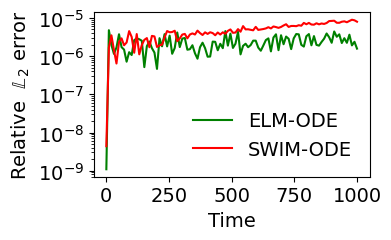

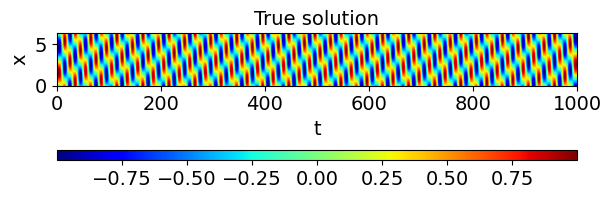

In [10]:
# Plot of error vs time for SWIM-ODE and ELM-ODE
# Figure parameters
from matplotlib.ticker import LogLocator, MaxNLocator
rc_fonts = {
    "text.usetex": False,
}
plt.rcParams.update(rc_fonts)
fontsize = 14
cmap =cm.jet
fig, ax = plt.subplots(1, 1, figsize=(4, 2.5), sharey=True)
ax.semilogy(t_eval, l2_rel_err_elms_avg, label='ELM-ODE', c='green')
ax.semilogy(t_eval, l2_rel_err_swims_avg, label='SWIM-ODE', c='red')
ax.legend(frameon=False, loc='lower right', fontsize=fontsize)
ax.set_xlabel('Time', fontsize=fontsize)
plt.ylabel(r'Relative  ' + r'$\mathbb{L}_{2}$ ' + r'error', fontsize=fontsize)
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))  # Major ticks at log scale
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))  # Minor ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
fig.tight_layout()
plt.savefig('adv_long_time_simulation.pdf')


# visualize the solution
fig, ax = plt.subplots(1, 1, figsize=(6, 3), constrained_layout=True)#
extent = [np.min(t_eval) , np.max(t_eval), np.min(x_space), np.max(x_space)]
aspect = 16
sol_img1 = ax.imshow(u_true_test.T, extent=extent, origin='lower', aspect=aspect, cmap=cmap)#, vmin=vlim[0], vmax=vlim[1]
cb = fig.colorbar(sol_img1, ax=ax, location='bottom',aspect=50)#, fraction=0.046 * 3 
ax.set_title('True solution', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.set_xlabel('t', fontsize=fontsize)
ax.set_ylabel('x', fontsize=fontsize)
plt.tick_params(axis='both', labelsize=fontsize)
plt.savefig('adv_true_sol.pdf')
